In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.ProposalScore(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

11/07/2018 23:16:39 ELBO=-6.43990784e+01 at epoch 1
11/07/2018 23:16:39 ELBO=-6.31011391e+01 at epoch 2
11/07/2018 23:16:39 ELBO=-6.10400887e+01 at epoch 3
11/07/2018 23:16:39 ELBO=-6.34848900e+01 at epoch 4
11/07/2018 23:16:40 ELBO=-6.42032928e+01 at epoch 5
11/07/2018 23:16:40 ELBO=-6.22332306e+01 at epoch 6
11/07/2018 23:16:40 ELBO=-6.16650963e+01 at epoch 7
11/07/2018 23:16:40 ELBO=-6.18312492e+01 at epoch 8
11/07/2018 23:16:40 ELBO=-6.30957985e+01 at epoch 9
11/07/2018 23:16:40 ELBO=-6.19971619e+01 at epoch 10
11/07/2018 23:16:40 ELBO=-6.26467361e+01 at epoch 11
11/07/2018 23:16:40 ELBO=-6.05494804e+01 at epoch 12
11/07/2018 23:16:41 ELBO=-6.08847122e+01 at epoch 13
11/07/2018 23:16:41 ELBO=-6.13867340e+01 at epoch 14
11/07/2018 23:16:41 ELBO=-6.25662727e+01 at epoch 15
11/07/2018 23:16:41 ELBO=-6.20933800e+01 at epoch 16
11/07/2018 23:16:41 ELBO=-6.39170532e+01 at epoch 17
11/07/2018 23:16:41 ELBO=-6.10708046e+01 at epoch 18
11/07/2018 23:16:41 ELBO=-6.47760849e+01 at epoch 19
11

Epoch   191: reducing learning rate of group 0 to 5.0000e-03.


11/07/2018 23:17:03 ELBO=-6.04874458e+01 at epoch 194
11/07/2018 23:17:03 ELBO=-6.28617897e+01 at epoch 195
11/07/2018 23:17:03 ELBO=-6.22510033e+01 at epoch 196
11/07/2018 23:17:03 ELBO=-6.23395653e+01 at epoch 197
11/07/2018 23:17:03 ELBO=-6.07859116e+01 at epoch 198
11/07/2018 23:17:03 ELBO=-6.11995583e+01 at epoch 199
11/07/2018 23:17:03 ELBO=-6.24228477e+01 at epoch 200
11/07/2018 23:17:03 ELBO=-6.20585442e+01 at epoch 201
11/07/2018 23:17:04 ELBO=-6.28065987e+01 at epoch 202
11/07/2018 23:17:04 ELBO=-6.18819084e+01 at epoch 203
11/07/2018 23:17:04 ELBO=-6.24338226e+01 at epoch 204
11/07/2018 23:17:04 ELBO=-6.27863007e+01 at epoch 205
11/07/2018 23:17:04 ELBO=-6.16005821e+01 at epoch 206
11/07/2018 23:17:04 ELBO=-6.10103912e+01 at epoch 207
11/07/2018 23:17:04 ELBO=-6.27819557e+01 at epoch 208
11/07/2018 23:17:04 ELBO=-6.21874008e+01 at epoch 209
11/07/2018 23:17:04 ELBO=-6.05619049e+01 at epoch 210
11/07/2018 23:17:04 ELBO=-6.31645241e+01 at epoch 211
11/07/2018 23:17:05 ELBO=-6.

Epoch   292: reducing learning rate of group 0 to 2.5000e-03.


11/07/2018 23:17:15 ELBO=-6.16724739e+01 at epoch 295
11/07/2018 23:17:15 ELBO=-6.16955986e+01 at epoch 296
11/07/2018 23:17:16 ELBO=-6.30892258e+01 at epoch 297
11/07/2018 23:17:16 ELBO=-6.15925903e+01 at epoch 298
11/07/2018 23:17:16 ELBO=-6.12105827e+01 at epoch 299
11/07/2018 23:17:16 ELBO=-6.20580025e+01 at epoch 300
11/07/2018 23:17:16 ELBO=-6.01696968e+01 at epoch 301
11/07/2018 23:17:16 ELBO=-6.21530533e+01 at epoch 302
11/07/2018 23:17:16 ELBO=-6.11486816e+01 at epoch 303
11/07/2018 23:17:17 ELBO=-6.15611954e+01 at epoch 304
11/07/2018 23:17:17 ELBO=-6.31825981e+01 at epoch 305
11/07/2018 23:17:17 ELBO=-6.16775131e+01 at epoch 306
11/07/2018 23:17:17 ELBO=-6.18293686e+01 at epoch 307
11/07/2018 23:17:17 ELBO=-6.30193100e+01 at epoch 308
11/07/2018 23:17:17 ELBO=-6.12111893e+01 at epoch 309
11/07/2018 23:17:17 ELBO=-6.10361595e+01 at epoch 310
11/07/2018 23:17:17 ELBO=-6.21967850e+01 at epoch 311
11/07/2018 23:17:17 ELBO=-6.31271820e+01 at epoch 312
11/07/2018 23:17:18 ELBO=-6.

Epoch   393: reducing learning rate of group 0 to 1.2500e-03.


11/07/2018 23:17:28 ELBO=-6.36305580e+01 at epoch 396
11/07/2018 23:17:28 ELBO=-6.20697060e+01 at epoch 397
11/07/2018 23:17:28 ELBO=-6.20070877e+01 at epoch 398
11/07/2018 23:17:28 ELBO=-6.06412010e+01 at epoch 399
11/07/2018 23:17:29 ELBO=-6.03170738e+01 at epoch 400
11/07/2018 23:17:29 ELBO=-6.28422012e+01 at epoch 401
11/07/2018 23:17:29 ELBO=-6.23650131e+01 at epoch 402
11/07/2018 23:17:29 ELBO=-6.29705582e+01 at epoch 403
11/07/2018 23:17:29 ELBO=-6.12704544e+01 at epoch 404
11/07/2018 23:17:29 ELBO=-6.19337502e+01 at epoch 405
11/07/2018 23:17:29 ELBO=-6.26362228e+01 at epoch 406
11/07/2018 23:17:29 ELBO=-6.22210007e+01 at epoch 407
11/07/2018 23:17:30 ELBO=-6.10585747e+01 at epoch 408
11/07/2018 23:17:30 ELBO=-6.07076836e+01 at epoch 409
11/07/2018 23:17:30 ELBO=-6.24036560e+01 at epoch 410
11/07/2018 23:17:30 ELBO=-6.01393661e+01 at epoch 411
11/07/2018 23:17:30 ELBO=-6.06143188e+01 at epoch 412
11/07/2018 23:17:30 ELBO=-6.25688515e+01 at epoch 413
11/07/2018 23:17:30 ELBO=-6.

Epoch   494: reducing learning rate of group 0 to 6.2500e-04.


11/07/2018 23:17:40 ELBO=-6.14659309e+01 at epoch 497
11/07/2018 23:17:40 ELBO=-6.11784782e+01 at epoch 498
11/07/2018 23:17:41 ELBO=-6.21715622e+01 at epoch 499
11/07/2018 23:17:41 ELBO=-6.30363121e+01 at epoch 500
11/07/2018 23:17:41 ELBO=-6.21737251e+01 at epoch 501
11/07/2018 23:17:41 ELBO=-6.04677315e+01 at epoch 502
11/07/2018 23:17:41 ELBO=-6.28056450e+01 at epoch 503
11/07/2018 23:17:41 ELBO=-6.31644630e+01 at epoch 504
11/07/2018 23:17:41 ELBO=-6.11385193e+01 at epoch 505
11/07/2018 23:17:41 ELBO=-6.06604576e+01 at epoch 506
11/07/2018 23:17:41 ELBO=-6.10318489e+01 at epoch 507
11/07/2018 23:17:42 ELBO=-6.15583878e+01 at epoch 508
11/07/2018 23:17:42 ELBO=-6.31146393e+01 at epoch 509
11/07/2018 23:17:42 ELBO=-6.16170387e+01 at epoch 510
11/07/2018 23:17:42 ELBO=-6.43519745e+01 at epoch 511
11/07/2018 23:17:42 ELBO=-6.16639633e+01 at epoch 512
11/07/2018 23:17:42 ELBO=-6.28202362e+01 at epoch 513
11/07/2018 23:17:42 ELBO=-6.30907021e+01 at epoch 514
11/07/2018 23:17:43 ELBO=-6.

Epoch   595: reducing learning rate of group 0 to 3.1250e-04.


11/07/2018 23:17:52 ELBO=-6.08245430e+01 at epoch 598
11/07/2018 23:17:53 ELBO=-6.11643639e+01 at epoch 599
11/07/2018 23:17:53 ELBO=-6.24854736e+01 at epoch 600
11/07/2018 23:17:53 ELBO=-6.20240440e+01 at epoch 601
11/07/2018 23:17:53 ELBO=-6.18662872e+01 at epoch 602
11/07/2018 23:17:53 ELBO=-6.09440460e+01 at epoch 603
11/07/2018 23:17:53 ELBO=-5.95817680e+01 at epoch 604
11/07/2018 23:17:53 ELBO=-6.31631470e+01 at epoch 605
11/07/2018 23:17:53 ELBO=-6.18265190e+01 at epoch 606
11/07/2018 23:17:54 ELBO=-6.15870285e+01 at epoch 607
11/07/2018 23:17:54 ELBO=-6.43601303e+01 at epoch 608
11/07/2018 23:17:54 ELBO=-6.35133057e+01 at epoch 609
11/07/2018 23:17:54 ELBO=-6.13364029e+01 at epoch 610
11/07/2018 23:17:54 ELBO=-6.46806870e+01 at epoch 611
11/07/2018 23:17:54 ELBO=-6.26561584e+01 at epoch 612
11/07/2018 23:17:54 ELBO=-6.28012695e+01 at epoch 613
11/07/2018 23:17:54 ELBO=-6.10208855e+01 at epoch 614
11/07/2018 23:17:55 ELBO=-6.14548836e+01 at epoch 615
11/07/2018 23:17:55 ELBO=-6.

Epoch   696: reducing learning rate of group 0 to 1.5625e-04.


11/07/2018 23:18:05 ELBO=-6.28716049e+01 at epoch 699
11/07/2018 23:18:05 ELBO=-6.18458443e+01 at epoch 700
11/07/2018 23:18:05 ELBO=-6.18130150e+01 at epoch 701
11/07/2018 23:18:05 ELBO=-6.10266571e+01 at epoch 702
11/07/2018 23:18:05 ELBO=-6.16951180e+01 at epoch 703
11/07/2018 23:18:05 ELBO=-6.14446793e+01 at epoch 704
11/07/2018 23:18:05 ELBO=-6.14662743e+01 at epoch 705
11/07/2018 23:18:06 ELBO=-6.20344162e+01 at epoch 706
11/07/2018 23:18:06 ELBO=-6.23708344e+01 at epoch 707
11/07/2018 23:18:06 ELBO=-6.29335060e+01 at epoch 708
11/07/2018 23:18:06 ELBO=-6.15714264e+01 at epoch 709
11/07/2018 23:18:06 ELBO=-6.19453430e+01 at epoch 710
11/07/2018 23:18:06 ELBO=-6.18601379e+01 at epoch 711
11/07/2018 23:18:06 ELBO=-6.15823250e+01 at epoch 712
11/07/2018 23:18:06 ELBO=-6.12604599e+01 at epoch 713
11/07/2018 23:18:07 ELBO=-6.29437561e+01 at epoch 714
11/07/2018 23:18:07 ELBO=-6.19590073e+01 at epoch 715
11/07/2018 23:18:07 ELBO=-6.10176277e+01 at epoch 716
11/07/2018 23:18:07 ELBO=-6.

Epoch   797: reducing learning rate of group 0 to 7.8125e-05.


11/07/2018 23:18:17 ELBO=-6.20636063e+01 at epoch 800
11/07/2018 23:18:17 ELBO=-6.20137749e+01 at epoch 801
11/07/2018 23:18:17 ELBO=-5.80348053e+01 at epoch 802
11/07/2018 23:18:17 ELBO=-6.01292534e+01 at epoch 803
11/07/2018 23:18:17 ELBO=-5.84870605e+01 at epoch 804
11/07/2018 23:18:17 ELBO=-6.10220413e+01 at epoch 805
11/07/2018 23:18:17 ELBO=-6.25499611e+01 at epoch 806
11/07/2018 23:18:18 ELBO=-6.30093193e+01 at epoch 807
11/07/2018 23:18:18 ELBO=-6.47076950e+01 at epoch 808
11/07/2018 23:18:18 ELBO=-6.16045113e+01 at epoch 809
11/07/2018 23:18:18 ELBO=-6.35844154e+01 at epoch 810
11/07/2018 23:18:18 ELBO=-6.30938759e+01 at epoch 811
11/07/2018 23:18:18 ELBO=-6.12336044e+01 at epoch 812
11/07/2018 23:18:18 ELBO=-6.34598045e+01 at epoch 813
11/07/2018 23:18:18 ELBO=-6.28209877e+01 at epoch 814
11/07/2018 23:18:18 ELBO=-6.21608124e+01 at epoch 815
11/07/2018 23:18:19 ELBO=-6.09834404e+01 at epoch 816
11/07/2018 23:18:19 ELBO=-6.24508591e+01 at epoch 817
11/07/2018 23:18:19 ELBO=-6.

Epoch   902: reducing learning rate of group 0 to 3.9063e-05.


11/07/2018 23:18:29 ELBO=-6.22008324e+01 at epoch 905
11/07/2018 23:18:29 ELBO=-6.33240166e+01 at epoch 906
11/07/2018 23:18:29 ELBO=-6.17729607e+01 at epoch 907
11/07/2018 23:18:30 ELBO=-6.31007881e+01 at epoch 908
11/07/2018 23:18:30 ELBO=-6.17993164e+01 at epoch 909
11/07/2018 23:18:30 ELBO=-6.09190140e+01 at epoch 910
11/07/2018 23:18:30 ELBO=-6.01819839e+01 at epoch 911
11/07/2018 23:18:30 ELBO=-6.27443848e+01 at epoch 912
11/07/2018 23:18:30 ELBO=-6.35669174e+01 at epoch 913
11/07/2018 23:18:30 ELBO=-6.13588371e+01 at epoch 914
11/07/2018 23:18:30 ELBO=-6.30264893e+01 at epoch 915
11/07/2018 23:18:30 ELBO=-6.22920914e+01 at epoch 916
11/07/2018 23:18:31 ELBO=-6.22154655e+01 at epoch 917
11/07/2018 23:18:31 ELBO=-6.18905296e+01 at epoch 918
11/07/2018 23:18:31 ELBO=-6.25859566e+01 at epoch 919
11/07/2018 23:18:31 ELBO=-6.12828331e+01 at epoch 920
11/07/2018 23:18:31 ELBO=-6.29036064e+01 at epoch 921
11/07/2018 23:18:31 ELBO=-6.19579735e+01 at epoch 922
11/07/2018 23:18:31 ELBO=-6.

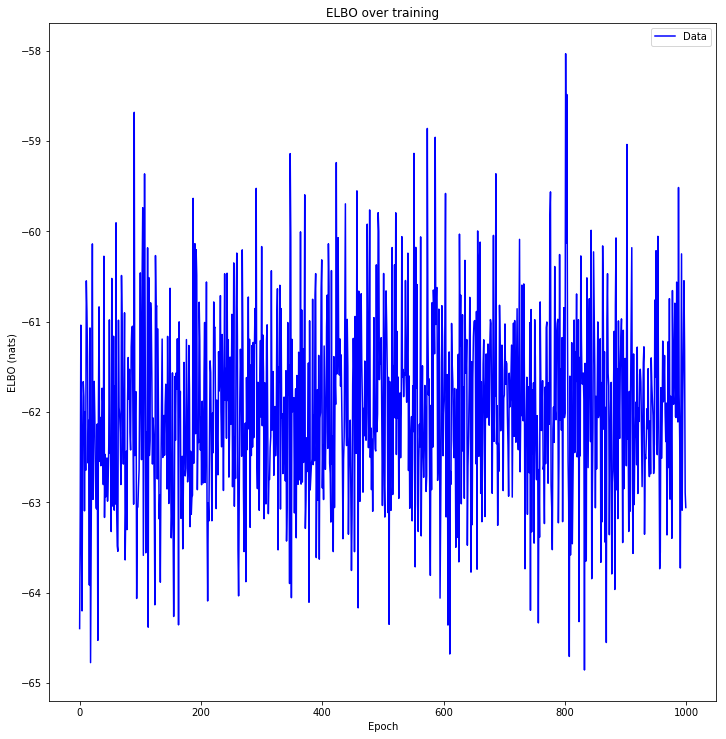

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.759203
SMC MSE at time 2: 0.702686
SMC MSE at time 3: 1.706247
SMC MSE at time 4: 0.817936
SMC MSE at time 5: 1.511515
SMC MSE at time 6: 0.625602
SMC MSE at time 7: 1.222425
SMC MSE at time 8: 1.136317
SMC MSE at time 9: 1.741763
SMC MSE at time 10: 0.707585
SMC MSE at time 11: 0.611897
SMC MSE at time 12: 2.061609
SMC MSE at time 13: 1.185832
SMC MSE at time 14: 1.195382
SMC MSE at time 15: 0.794580
SMC MSE at time 16: 1.584805
SMC MSE at time 17: 0.621571
SMC MSE at time 18: 0.768850
SMC MSE at time 19: 1.434378
SMC MSE at time 20: 0.504706
SMC MSE at time 21: 0.669402
SMC MSE at time 22: 1.720306
SMC MSE at time 23: 0.614811
SMC MSE at time 24: 1.825400
SMC MSE at time 25: 1.478832
SMC MSE at time 26: 0.742992
SMC MSE at time 27: 0.856245
SMC MSE at time 28: 0.933877
SMC MSE at time 29: 0.853358
SMC MSE at time 30: 0.755348
SMC MSE at time 31: 0.796385
SMC MSE at time 32: 1.025903
SMC MSE at time 33: 0.712536
SMC MSE at time 34: 0.722190
SMC MSE at time 35: 0.8

In [15]:
particle_mh = mcmc.IndependentMH(smc_ssm, ssm_proposal, 1000)

NameError: name 'smc_ssm' is not defined

In [ ]:
samples, elbos = particle_mh(trace=importance.ResamplerTrace(num_particles, data=data))
inference = particle_mh.trace

In [ ]:
inference

In [ ]:
generative

In [ ]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

In [ ]:
elbos